# Stock Graph Analysis Notebook

This notebook generates three graph analyses for a selected NYSE stock universe:

1. **Lead-Lag Analysis** (Granger causality directed graph)
2. **News Co-Occurrence Analysis** (undirected co-mention graph)
3. **Inter-Company Relationship Analysis** (directed relationship graph)

---



## Dependencies Installation

In [1]:
# Install required libraries
!pip install yfinance statsmodels networkx tqdm newsapi-python matplotlib



---

## Section 1: Lead-Lag Analysis

### 1.1 Imports and Configuration




In [7]:
# Standard libraries
import pandas as pd
import numpy as np
from itertools import combinations

# Time series and statistics
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests

# Graphs and visualization
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Notebook display settings
%matplotlib inline


### 1.2 Define Stock Universe & Date Range


In [3]:
# NYSE tickers to analyze
STOCKS = [
    'AAPL','MSFT','ORCL','NVDA','AMD','INTC',
    'GOOGL','META','NFLX','DIS','T','VZ',
    'JPM','BAC','GS','MS','WFC','V','MA',
    'JNJ','PFE','MRK','UNH','CVS','WBA',
    'AMZN','WMT','TGT','COST','HD','LOW','TSLA','GM','F',
    'KO','PEP','PG',
    'FDX','UPS','BA','CAT','LMT','UNP',
    'XOM','CVX',
    'FCX','NEM',
    'AMT','PLD',
    'NEE','DUK'
]
START_DATE = '2020-01-01'
END_DATE   = '2025-01-01'


### 1.3 Data Download and Preprocessing


In [4]:
def extract_price(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the adjusted-close (or close) price DataFrame from yfinance output.

    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe returned by yf.download for multiple tickers.

    Returns
    -------
    pd.DataFrame
        Columns are tickers and rows are daily prices, NaN columns dropped.
    """
    # handle multi-index
    if isinstance(df.columns, pd.MultiIndex):
        fields = list(df.columns.levels[0])
        key = next((f for f in fields if f.lower()=='adj close'),
                   next((f for f in fields if f.lower()=='close'), None))
        price = df[key].copy()
    else:
        cols = list(df.columns)
        key = next((c for c in cols if c.lower()=='adj close'),
                   next((c for c in cols if c.lower()=='close'), None))
        price = df[[key]].copy()
        price.columns = STOCKS
    return price.dropna(axis=1, how='all')

# Download price data
raw = yf.download(STOCKS, start=START_DATE, end=END_DATE)
price = extract_price(raw)
print(f"Price data shape: {price.shape}")

# Compute daily returns
returns = price.pct_change().dropna()
print(f"Returns data shape: {returns.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  51 of 51 completed


Price data shape: (1258, 51)
Returns data shape: (1257, 51)


### 1.4 Lead-Lag (Granger) Analysis


In [5]:
def granger_test(x: pd.Series, y: pd.Series, maxlag: int = 3):
    """
    Perform Granger causality test of x causing y and return smallest p-value and lag.
    """
    df = pd.concat([y, x], axis=1).dropna()
    res = grangercausalitytests(df, maxlag=maxlag, verbose=False)
    pvals = [res[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
    return float(np.min(pvals)), int(np.argmin(pvals) + 1)

results = []
corr_matrix = returns.corr()
for x, y in tqdm(combinations(price.columns, 2), desc="Analyzing pairs"):
    r = corr_matrix.loc[x, y]
    if abs(r) < 0.5:
        continue
    px, lag_x = granger_test(returns[x], returns[y])
    py, lag_y = granger_test(returns[y], returns[x])
    if px < 0.05:
        direction, pval, lag = f"{x}→{y}", px, lag_x
    elif py < 0.05:
        direction, pval, lag = f"{y}→{x}", py, lag_y
    else:
        direction, pval, lag = "None", None, None
    results.append([x, y, r, direction, pval, lag])

df_leadlag = pd.DataFrame(
    results,
    columns=['Stock_X','Stock_Y','Correlation','GrangerDirection','PValue','Lag']
)
df_leadlag.to_csv('lead_lag_graph.csv', index=False)
print("Saved lead_lag_graph.csv")
df_leadlag.head(10)

Analyzing pairs: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
Analyzing pairs: 3it [00:00, 27.42it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: F

Saved lead_lag_graph.csv


,Stock_X,Stock_Y,Correlation,GrangerDirection,PValue,Lag
0,AAPL,AMD,0.561703,AAPL→AMD,0.001487,1.0
1,AAPL,AMZN,0.592200,AAPL→AMZN,0.000354,1.0
2,AAPL,COST,0.564239,AAPL→COST,0.004652,2.0
3,AAPL,GOOGL,0.648932,AAPL→GOOGL,0.005018,1.0
4,AAPL,HD,0.556465,AAPL→HD,0.000015,1.0
5,AAPL,LOW,0.518337,AAPL→LOW,0.000538,3.0
6,AAPL,MA,0.592051,AAPL→MA,0.004881,1.0
7,AAPL,META,0.563116,AAPL→META,0.000970,1.0
8,AAPL,MSFT,0.748327,AAPL→MSFT,0.009254,3.0
9,AAPL,NVDA,0.606399,AAPL→NVDA,0.002119,1.0


### 1.5 Visualize Lead-Lag Graph


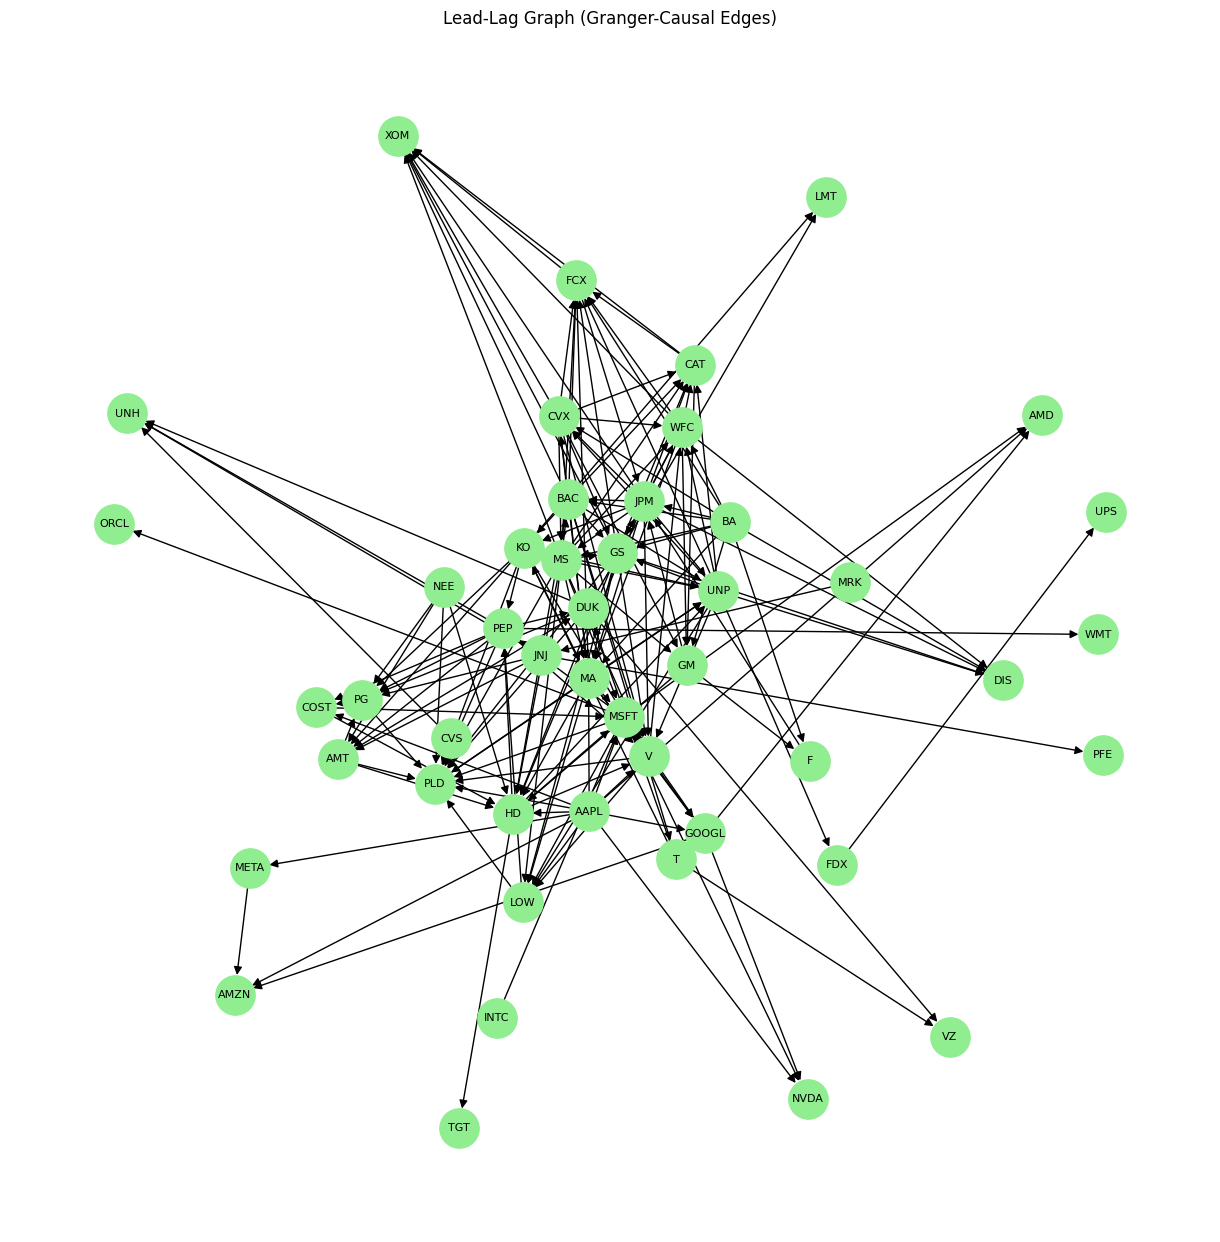

In [8]:
# Build directed graph of significant Granger-caused edges
G = nx.DiGraph()
for _, row in df_leadlag.iterrows():
    if row['GrangerDirection'] != 'None':
        src, tgt = row['GrangerDirection'].split('→')
        G.add_edge(src, tgt, weight=row['Correlation'])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color='lightgreen',
    arrowsize=12,
    font_size=8
)
plt.title("Lead-Lag Graph (Granger-Causal Edges)")
plt.show()

---

## Section 2: News Co-Occurrence Analysis

> **Note:** We rotate through 20 NewsAPI keys (100 requests/day each).  
> Keys reset hourly and next reset occurs on **April 20, 2025 at 17:00 EST**.

### 2.1 NewsAPI Crawler with Key Rotation


In [ ]:
from newsapi import NewsApiClient
from newsapi.newsapi_client import NewsAPIException
from datetime import datetime, timedelta
import re, time

API_KEYS = [
    "5acf40be55e542a3940ccad3cef31b29", "0cab229ea9684f7fab4dfa72623783f6",
    "f978d6cd6c8f4fb29058ef2444ab5a8d", "b0d8009fa1fe4069b947778be4a5a63a",
    "bc7a5b0fc2a34884947d818a593e1315", "9f2f52fa42b14590850c333b21d96a7d",
    "666f92f03b0c42529bdab8622416a57e", "3b03f23fcb004fc9b513ce608f8aa976",
    "78bc1acd51f0425299bc8abfe28067db", "a45d02fb22434c6183c137f2f63b267e",
    "54498c9cf47f4244ac5109cfc2440816", "0e7e0d771374457a881273b1dab48e27",
    "75bef412a48a4aecb66ed9391b525578", "c970aaebe5724335b2153f535648b05d",
    "b141ed637d3f4b9eb1c482813c4cf86c", "a833c9ac95104c75a583b27b0f5e9f2e",
    "7c7b5a4168554df38eea2888d24d6ac0", "c83ab994ca6748d8ac95233d5ef3af07",
    "abc39661963e47c6b512cf0b3ccec9ab", "81dc240952b1494ea578445357a4991d",
]
MAX_REQS_PER_KEY = 99
key_ptr = 0
key_usage = {k: 0 for k in API_KEYS}


def next_client() -> tuple[NewsApiClient,str]:
    """
    Return a NewsApiClient with an unused key (round-robin),
    skipping keys at daily cap.
    """
    global key_ptr
    for _ in API_KEYS:
        k = API_KEYS[key_ptr]
        key_ptr = (key_ptr + 1) % len(API_KEYS)
        if key_usage[k] < MAX_REQS_PER_KEY:
            key_usage[k] += 1
            return NewsApiClient(api_key=k), k
    raise RuntimeError("All keys have reached daily limit.")

ALIASES = {
    "AAPL": ["Apple Inc", "Apple"],
    "MSFT": ["Microsoft", "Microsoft Corp"],
    "ORCL": ["Oracle", "Oracle Corp"],
    "NVDA": ["NVIDIA", "NVIDIA Corp"],
    "AMD" : ["Advanced Micro Devices", "AMD"],
    "INTC": ["Intel", "Intel Corp"],
    "GOOGL":["Alphabet Inc", "Google"],
    "META":["Meta Platforms", "Facebook"],
    "NFLX":["Netflix"],
    "DIS" : ["Walt Disney", "Disney"],
    "T"   : ["AT&T"],
    "VZ"  : ["Verizon"],
    "JPM" : ["JPMorgan Chase", "JPMorgan"],
    "BAC" : ["Bank of America"],
    "GS"  : ["Goldman Sachs"],
    "MS"  : ["Morgan Stanley"],
    "WFC" : ["Wells Fargo"],
    "V"   : ["Visa Inc"],
    "MA"  : ["Mastercard"],
    "JNJ" : ["Johnson & Johnson"],
    "PFE" : ["Pfizer"],
    "MRK" : ["Merck & Co", "Merck"],
    "UNH" : ["UnitedHealth Group"],
    "CVS" : ["CVS Health", "CVS Pharmacy"],
    "WBA" : ["Walgreens Boots Alliance", "Walgreens"],
    "AMZN":["Amazon.com", "Amazon"],
    "WMT" : ["Walmart"],
    "TGT" : ["Target Corp", "Target"],
    "COST":["Costco Wholesale", "Costco"],
    "HD"  : ["Home Depot", "The Home Depot"],
    "LOW" : ["Lowe's", "Lowes"],
    "TSLA":["Tesla Inc", "Tesla"],
    "GM"  : ["General Motors"],
    "F"   : ["Ford Motor", "Ford"],
    "KO"  : ["Coca‑Cola", "Coca Cola"],
    "PEP" : ["PepsiCo", "Pepsi"],
    "PG"  : ["Procter & Gamble", "Procter and Gamble", "P&G"],
    "FDX" : ["FedEx", "FedEx Corp"],
    "UPS" : ["United Parcel Service", "UPS"],
    "BA"  : ["Boeing", "Boeing Company"],
    "CAT" : ["Caterpillar Inc", "Caterpillar"],
    "LMT" : ["Lockheed Martin"],
    "UNP" : ["Union Pacific"],
    "XOM" : ["Exxon Mobil", "ExxonMobil"],
    "CVX" : ["Chevron Corp", "Chevron"],
    "FCX" : ["Freeport‑McMoRan", "Freeport McMoRan"],
    "NEM" : ["Newmont Corp", "Newmont"],
    "AMT" : ["American Tower", "American Tower Corp"],
    "PLD" : ["Prologis", "Prologis Inc"],
    "NEE" : ["NextEra Energy", "NextEra"],
    "DUK" : ["Duke Energy", "Duke Energy Corp"],
}
PATTERNS = { t: re.compile(r"\b("+"|".join(map(re.escape,names))+r")\b",re.I)
            for t,names in ALIASES.items() }

# Define date range
END = datetime.utcnow().date()
START = END - timedelta(days=30)
DAY_RANGE = (END - START).days + 1

articles, seen_urls = [], set()
for d in tqdm(range(DAY_RANGE), desc="Days"):
    date_str = (START + timedelta(days=d)).strftime("%Y-%m-%d")
    for sym, pattern in PATTERNS.items():
        page = 1
        while True:
            client, key = next_client()
            try:
                res = client.get_everything(
                    q=pattern.pattern,
                    from_param=date_str,
                    to=date_str,
                    language='en',
                    page_size=100,
                    page=page
                )
            except NewsAPIException as e:
                code = getattr(e, 'error', {}).get('code')
                if code == 'rateLimited':
                    key_usage[key] -= 1
                    time.sleep(60)
                    continue
                break
            arts = res.get('articles', [])
            if not arts:
                break
            for art in arts:
                url = art.get('url')
                if url and url not in seen_urls:
                    seen_urls.add(url)
                    articles.append(art)
            if len(arts) < 100:
                break
            page += 1
            time.sleep(0.2)

# Build co-occurrence matrix and save
co, urls = {}, {}
for a in articles:
    text = f"{a.get('title','')} {a.get('description','')}"
    tickers = sorted({t for t,p in PATTERNS.items() if p.search(text)})
    for x,y in combinations(tickers,2):
        co[(x,y)] = co.get((x,y),0) + 1
        urls.setdefault((x,y), set()).add(a['url'])

df_news = pd.DataFrame([
    {'Source':x,'Target':y,'CoMentionCount':n,'URLs':"; ".join(sorted(urls[(x,y)]))}
    for (x,y),n in co.items()
]).sort_values('CoMentionCount', ascending=False)
df_news.to_csv('news_cooccurrence_graph.csv', index=False)
print(f"Collected {len(articles)} unique articles")
print("Saved news_cooccurrence_graph.csv")


### 2.2 Visualize News Co-Occurrence Graph

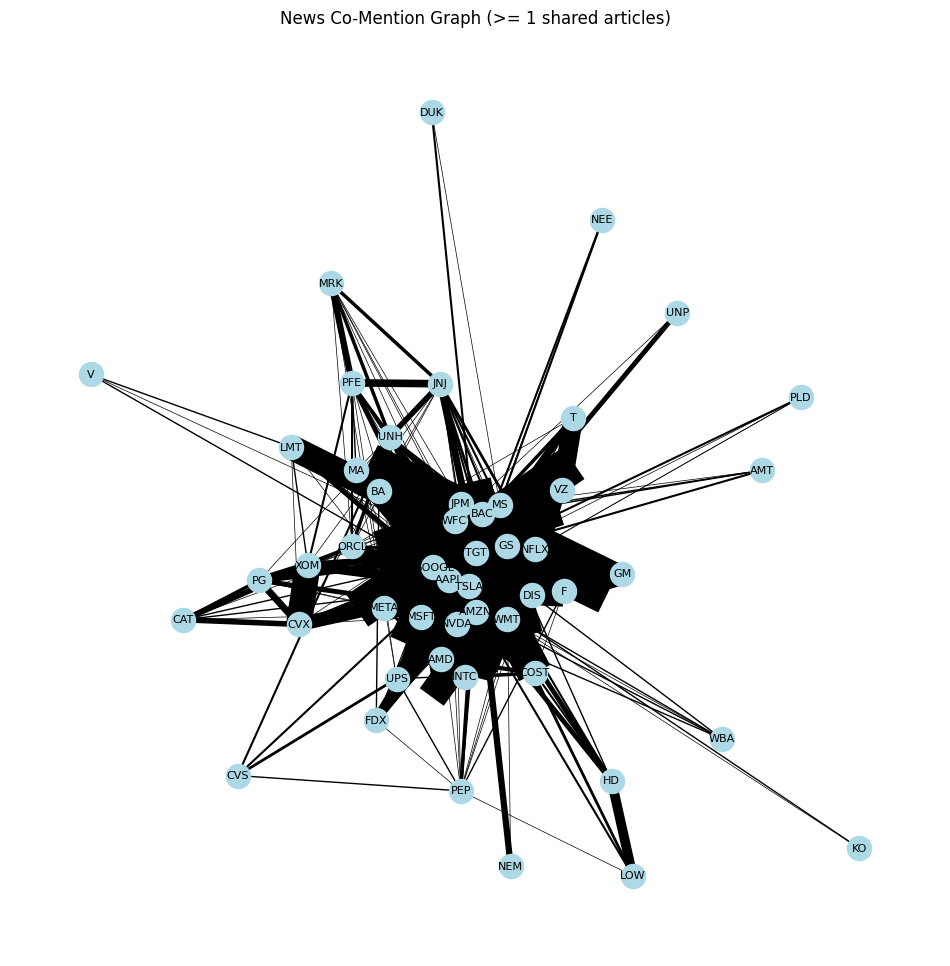

In [9]:
co_df = pd.read_csv('news_cooccurrence_graph.csv')
MIN_COUNT = 1  # threshold to prune low-frequency edges
edges = co_df[co_df.CoMentionCount >= MIN_COUNT]

G_news = nx.Graph()
for _, row in edges.iterrows():
    G_news.add_edge(row.Source, row.Target, weight=row.CoMentionCount)

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_news, k=0.5, seed=42)
weights = [G_news[u][v]['weight'] for u,v in G_news.edges()]

nx.draw_networkx(
    G_news, pos,
    node_color='lightblue',
    width=[w/2 for w in weights],
    with_labels=True,
    font_size=8
)
plt.title(f"News Co-Mention Graph (>= {MIN_COUNT} shared articles)")
plt.axis('off')
plt.show()

---

## Section 3: Inter-Company Relationship Analysis

### 3.1 Load Relationship Data and Build Graph

In [10]:
# Load your pre-generated relationships file
df_rel = pd.read_csv('business_relationship_graph.csv')

# Map confidence levels to numeric weights
CONFIDENCE_MAP = {'High':1.0,'Medium':0.6,'Low':0.3}
df_rel['Weight'] = df_rel['ConfidenceLevel'].map(CONFIDENCE_MAP)

# Encode relation types
REL_TYPES = df_rel['RelationType'].unique().tolist()
REL_MAP = {rel:i for i,rel in enumerate(REL_TYPES)}
df_rel['RelationTypeID'] = df_rel['RelationType'].map(REL_MAP)

# Build directed graph
G_rel = nx.DiGraph()
for _, row in df_rel.iterrows():
    G_rel.add_edge(
        row.Source, row.Target,
        weight=row.Weight,
        label=row.RelationType,
        type_id=row.RelationTypeID
    )

print(f"Built inter-company graph: {G_rel.number_of_nodes()} nodes, {G_rel.number_of_edges()} edges")

Built inter-company graph: 50 nodes, 87 edges


### 3.2 Visualize Inter-Company Relationship Graph


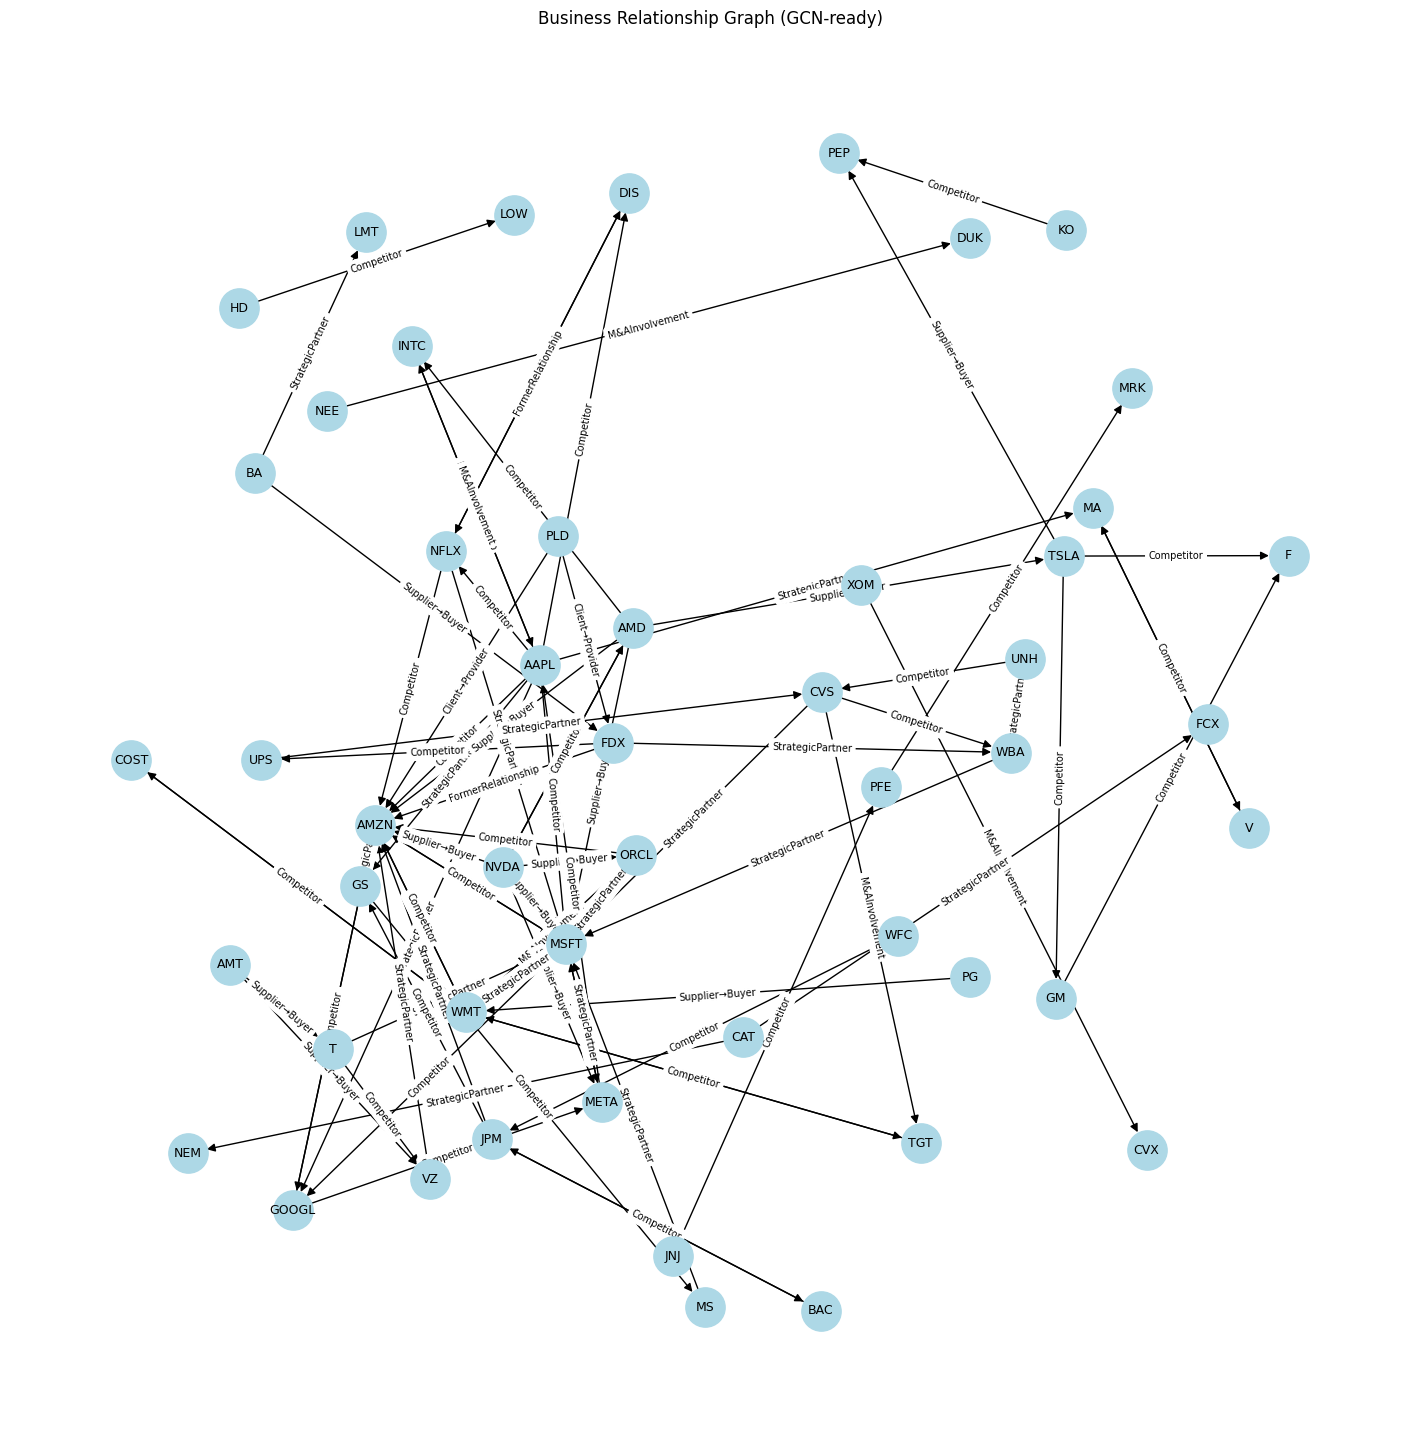

In [11]:
plt.figure(figsize=(14,14))
pos = nx.spring_layout(G_rel, k=0.7, seed=42)
edge_labels = {(u,v):d['label'] for u,v,d in G_rel.edges(data=True)}

nx.draw(
    G_rel, pos,
    with_labels=True,
    node_size=800,
    node_color='lightblue',
    arrowsize=12,
    font_size=9
)
nx.draw_networkx_edge_labels(G_rel, pos, edge_labels=edge_labels, font_size=7)
plt.title("Business Relationship Graph (GCN-ready)")
plt.axis('off')
plt.show()